# What drives the price of a car?

![](images/kurt.jpeg)


**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing. Your goal is to understand what factors make a car more or less expensive. As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.


**CRISP-DM Framework**

To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM. This process provides a framework for working through a data problem. Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip). After reading the overview, answer the questions below.


## A. Business Understanding


**Problem Statement**: Create a machine learning model to predict car prices, and advise a used car dealership on inventory management based on what consumers value in a used car.

**Tasks**:

a. **Data understanding**: Understand the key attributes and its relationship to price.  
b. **Data Preparation**: Clean, transform, and select key features to retain for modelling.  
c. **Model Building**: Create a machine learning model to predict car prices.  
d. **Model Evaluation**: Compare against other possible models to recommend the best one.


##### _Step 1: Load the Relevant Libraries_


In [32]:
# Import Libraries
# The basics 
import numpy as np
import pandas as pd

# Importing  tools for visualization
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt

# Import tools for data preprocessing and pipelines 
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel 

# Import tools for model creation 
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# Import evaluation metric libraries
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

# Import model selection libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


##### _Step 2: Load the Data and Take a Look_


In [33]:
cars = pd.read_csv('data/vehicles.csv')
cars.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


Look through the data systematically, with visuals as appropriate:

1. Start with **general characteristics** such as number of rows and columns, NULL values and significant data losses.
2. Then move on to explore key descriptive statistical features of the **numerical features**, in particular that of the target feature "price".
3. Thereafter move on to explore the **categorical features** to see what they are, the number of unique values, and consider how these could be encoded or dropped later on during modelling.
4. Lastly, do a random check of similar columns to see if there may be repetitive features that would add little value to the model later and might also reduce chances of **multicollinearity**


##### _Step 3: Explore General Characteristics_


In [34]:
#explore general features of each column and #null values 
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

**General Observations**

- 14 of the 18 rows have NULL values.
- 6 of the 14 (`condition`, `cylinders`, `VIN`, `drive`, `size`, and `paint_color`) only have about half of its values filled.


##### _Step 4: Explore Numerical Features_


In [35]:
#Explore the numerical features
cars.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


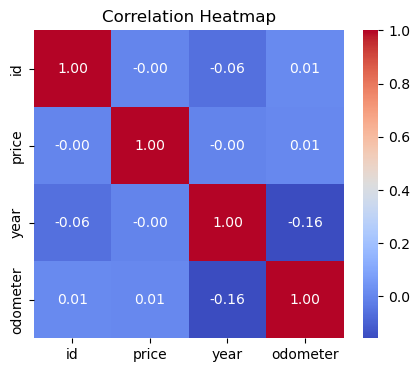

In [36]:
# Plot the correlation heatmap of only the numerical columns in the dataset
numerical_cols = cars.select_dtypes(include=[np.number])
plt.figure(figsize=(5, 4))
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()

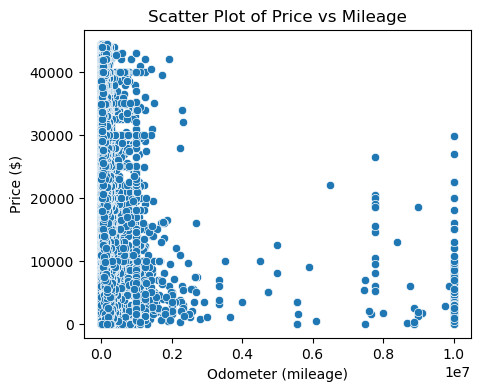

In [37]:
# Scatter plot of price against mileage, after removing outliers
price_95 = cars['price'].quantile(0.95)
cars_filtered = cars[(cars['price'] <= price_95)]

plt.figure(figsize=(5, 4))
sns.scatterplot(data=cars_filtered, x='odometer', y='price')
plt.xlabel('Odometer (mileage)')
plt.ylabel('Price ($)')
plt.title('Scatter Plot of Price vs Mileage')
plt.show()

**Numerical Observations 4a**

- The cars in the dataset were aged from `year` 1900 to 2022
- `price` ranged from 0 to 3.7B, with significant variance due to outliers.
- There is no clear correlation between any of the numerical features and `year`
- `price` generally is higher for lower mileage cars


##### _Step 5: Explore Categorical Features_


In [38]:
#Explore categorical values of the cars df

cat_columns = cars.select_dtypes(exclude="number").columns

cat_columns_values = []
for col in cat_columns:
    nunique = cars[col].nunique()
    unique_vals = cars[col].unique()
    cat_columns_values.append({
        'column': col,
        'nunique': nunique,
        'unique_values': unique_vals
    })
cat_columns_df = pd.DataFrame(cat_columns_values)
cat_columns_df 

,column,nunique,unique_values
0,region,404,"[prescott, fayetteville, florida keys, worcest..."
1,manufacturer,42,"[nan, gmc, chevrolet, toyota, ford, jeep, niss..."
2,model,29649,"[nan, sierra 1500 crew cab slt, silverado 1500..."
3,condition,6,"[nan, good, excellent, fair, like new, new, sa..."
4,cylinders,8,"[nan, 8 cylinders, 6 cylinders, 4 cylinders, 5..."
5,fuel,5,"[nan, gas, other, diesel, hybrid, electric]"
6,title_status,6,"[nan, clean, rebuilt, lien, salvage, missing, ..."
7,transmission,3,"[nan, other, automatic, manual]"
8,VIN,118246,"[nan, 3GTP1VEC4EG551563, 1GCSCSE06AZ123805, 3G..."
9,drive,3,"[nan, rwd, 4wd, fwd]"


**Categorical Observations 5a**

- `model`, `VIN`, and `region` have exceptionally high cardinality


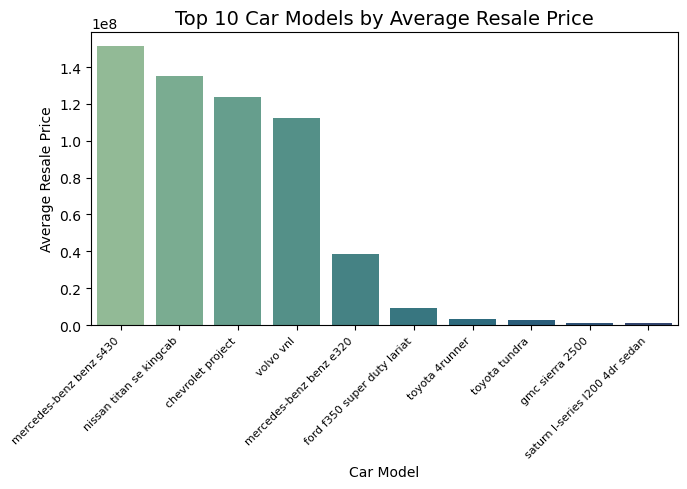

In [39]:
# Plot the Top 10 manufacturers based on average resale price 
top_10_models = (
    cars.groupby(['manufacturer', 'model'])['price']
        .mean()
        .sort_values(ascending=False)
        .head(10)
        .reset_index()                    
)

top_10_models['manu_model'] = (
    top_10_models['manufacturer'] + ' ' + top_10_models['model']
)

plt.figure(figsize=(7,5))
sns.barplot(x='manu_model', y='price',
            data=top_10_models, palette='crest')
plt.title('Top 10 Car Models by Average Resale Price', fontsize=14)
plt.xlabel('Car Model', fontsize=10)
plt.ylabel('Average Resale Price', fontsize=10)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.tight_layout()
plt.show()

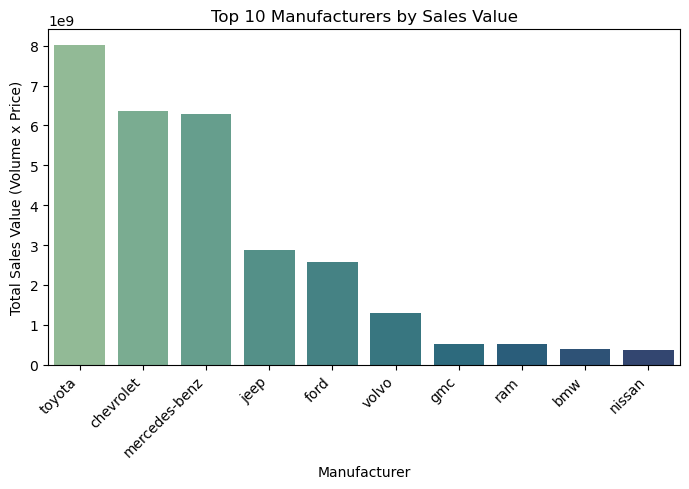

In [40]:
# Plot the Top 10 manufacturers based on Total Sales Value (i.e. count x price) 
top_10 = cars.groupby('manufacturer')['price'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(7,5))
sns.barplot(x=top_10.index, y=top_10.values, palette='crest')
plt.title('Top 10 Manufacturers by Sales Value')
plt.xlabel('Manufacturer')
plt.ylabel('Total Sales Value (Volume x Price)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Categorical Observations 5b**

- mercedes benz, chevrolet, and toyota are top in terms of both total value and sales count
- to consider dropping model since `manufacturer` can be representative


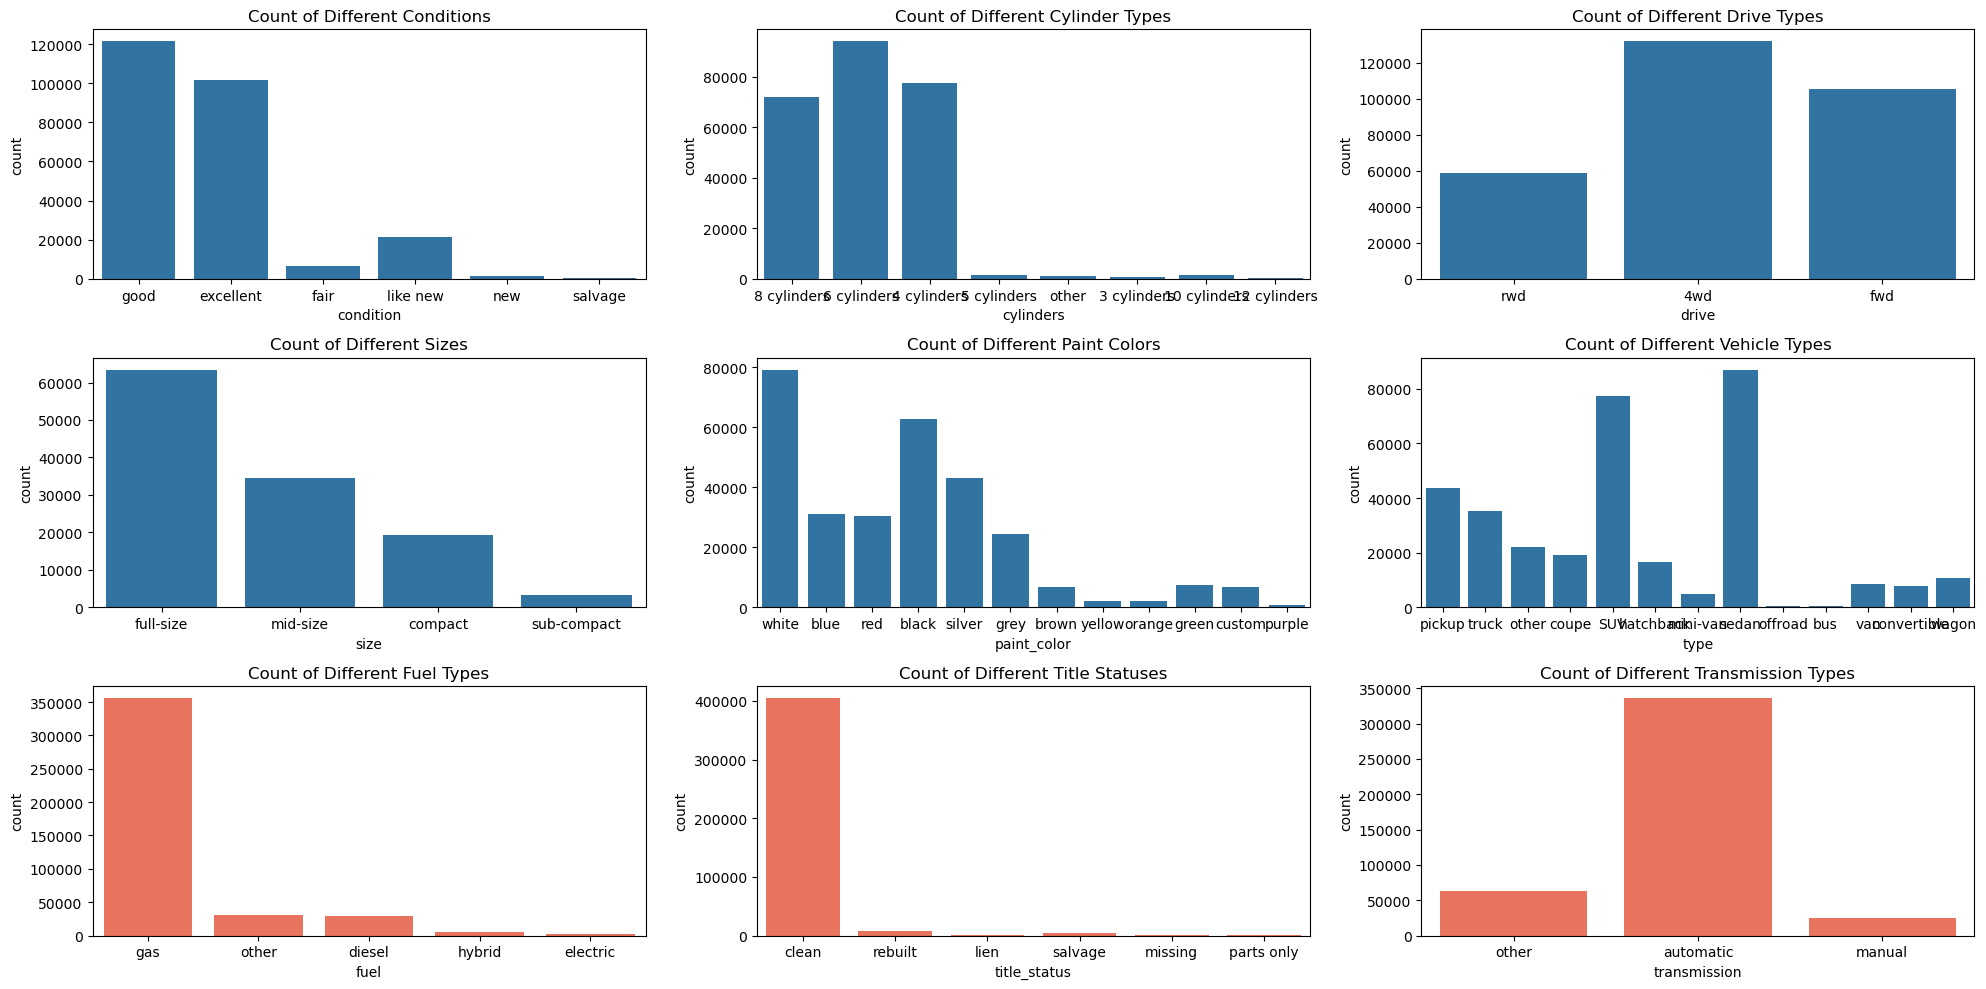

In [41]:
# Observe distribution of categorical features based on count 
plt.figure(figsize=(20,10))

# Subplot 1: Count of different conditions 
plt.subplot(3,3,1)
sns.countplot(data=cars, x = 'condition')
plt.title("Count of Different Conditions")

# Subplot 2: Count of different cylinder types 
plt.subplot(3,3,2)
sns.countplot(data=cars, x = 'cylinders')
plt.title("Count of Different Cylinder Types")

# Subplot 3: Count of different drive types 
plt.subplot(3,3,3)
sns.countplot(data=cars, x = 'drive')
plt.title("Count of Different Drive Types")

# Subplot 4: Count of different sizes  
plt.subplot(3,3,4)
sns.countplot(data=cars, x = 'size')
plt.title("Count of Different Sizes")

# Subplot 5: Count of different colors  
plt.subplot(3,3,5)
sns.countplot(data=cars, x = 'paint_color')
plt.title("Count of Different Paint Colors")

# Subplot 6: Count of different vehicle types  
plt.subplot(3,3,6)
sns.countplot(data=cars, x = 'type')
plt.title("Count of Different Vehicle Types")

# Subplot 7: Count of different fuel types 
plt.subplot(3,3,7)
sns.countplot(data=cars, x = 'fuel', color="tomato")
plt.title("Count of Different Fuel Types")

# Subplot 8: Count of different title status  
plt.subplot(3,3,8)
sns.countplot(data=cars, x = 'title_status', color="tomato")
plt.title("Count of Different Title Statuses")

# Subplot 9: Count of different transmission types 
plt.subplot(3,3,9)
sns.countplot(data=cars, x = 'transmission', color="tomato")
plt.title("Count of Different Transmission Types")

# Display the plot
plt.tight_layout()
plt.show()

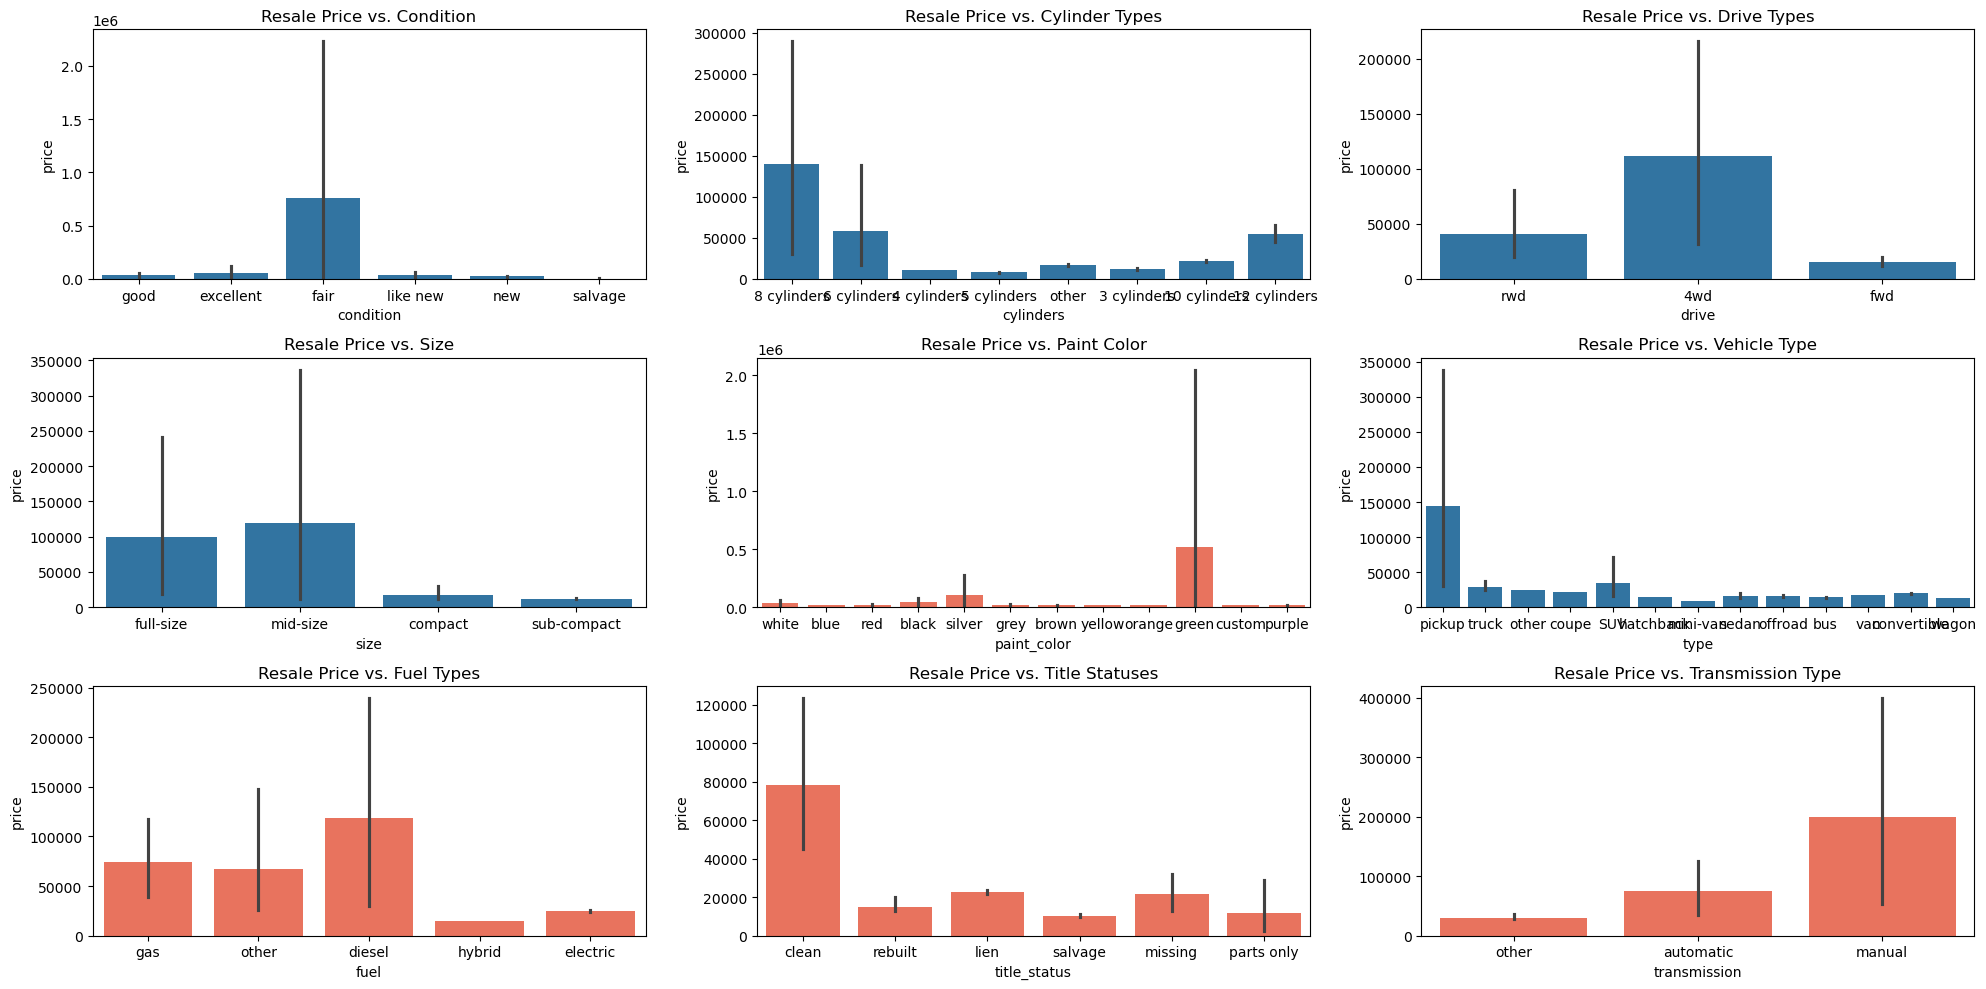

In [42]:
# Observe relationship between categorical features and price 
plt.figure(figsize=(20,10))

# Subplot 1: Plot of price vs condition 
plt.subplot(3,3,1)
sns.barplot(data=cars, x='condition', y='price')
plt.title('Resale Price vs. Condition')

# Subplot 2: Price vs cylinder types 
plt.subplot(3,3,2)
sns.barplot(data=cars, x='cylinders', y='price')
plt.title('Resale Price vs. Cylinder Types')

# Subplot 3: Price vs drive types 
plt.subplot(3,3,3)
sns.barplot(data=cars, x='drive', y='price')
plt.title('Resale Price vs. Drive Types')

# Subplot 4: Price vs vehicle size  
plt.subplot(3,3,4)
sns.barplot(data=cars, x='size', y='price')
plt.title('Resale Price vs. Size')

# Subplot 5: Price vs different colors  
plt.subplot(3,3,5)
sns.barplot(data=cars, x='paint_color', y='price', color="tomato")
plt.title('Resale Price vs. Paint Color')

# Subplot 6: Price vs vehicle types  
plt.subplot(3,3,6)
sns.barplot(data=cars, x='type', y='price')
plt.title('Resale Price vs. Vehicle Type')

# Subplot 7: Price vs fuel types 
plt.subplot(3,3,7)
sns.barplot(data=cars, x='fuel', y='price', color = "tomato")
plt.title('Resale Price vs. Fuel Types')

# Subplot 8: Price vs title status  
plt.subplot(3,3,8)
sns.barplot(data=cars, x='title_status', y='price', color="tomato")
plt.title('Resale Price vs. Title Statuses')

# Subplot 9: Price vs transmission types 
plt.subplot(3,3,9)
sns.barplot(data=cars, x='transmission', y='price', color="tomato")
plt.title('Resale Price vs. Transmission Type')

# Display the plot
plt.tight_layout()
plt.show()

In [43]:
# Count the number of green car sales in the dataset
num_green_cars = cars[cars['paint_color'] == 'green'].shape[0]
print(f'Number of green car sales: {num_green_cars}')

# Compute mean, min, and max price of green car sales
green_cars = cars[cars['paint_color'] == 'green']
mean_price = green_cars['price'].mean()
min_price = green_cars['price'].min()
max_price = green_cars['price'].max()
print(f'Mean price of green car sales: ${mean_price:,.2f}')
print(f'Min price of green car sales: ${min_price:,.2f}')
print(f'Max price of green car sales: ${max_price:,.2f}')

# Calculate number of green car sales with price greater than 1 billion
num_green_cars_over_1b = green_cars[green_cars['price'] > 1_000_000_000].shape[0]
print(f'Number of green car sales with price > $1B: {num_green_cars_over_1b}')

Number of green car sales: 7343
Mean price of green car sales: $522,128.65
Min price of green car sales: $0.00
Max price of green car sales: $3,736,928,711.00
Number of green car sales with price > $1B: 1


**Categorical Observations 5c**

- gas `fuel_type`, clean `title_status`, and automatic `transmission` are clearly popular characteristics
- However, these features have near zero variance and will not be useful for modelling
- vehicle `paint_color` does not affect price as much, with the exception of a green color datapoint that was skewed by a single sale worth >$3B.


In [44]:
#check remaining categorical values with significant missing data to determine whether to retain feature in modelling
#cars.groupby('condition')['price'].count().sort_values(ascending=False).head(20)
#cars.groupby('paint_color')['price'].count().sort_values(ascending=False).head(20)
#cars.groupby('state')['price'].median().sort_values(ascending=False).head(20)

# Calculate median car sale value for each state
cars['state'] = cars['state'].str.upper()
state_median = cars.groupby('state')['price'].median().reset_index()


# Plot choropleth
fig = px.choropleth(
    state_median,
    locations='state',
    locationmode='USA-states',
    color='price',
    color_continuous_scale='Blues',
    scope='usa',
    labels={'price': 'Median Sale Price'},
    title='Median Car Sale Value by State'
)
fig.show()

**Categorical Observations 5d**

- Effect of `state` on price appears minimal with relatively even spread across states
- Median range of 10k - 25k sale price for lowest to highest priced states


## B. Data Preparation


##### _Step 6: Handle Outliers_


In [45]:
#Remove outliers from the 'price' column using the Tukey method (IQR rule)
Q1 = cars['price'].quantile(0.25)
Q3 = cars['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
cars_clean = cars[(cars['price'] >= lower_bound) & (cars['price'] <= upper_bound)]

##### _Step 7: Simplify the Manufacturer Feature_


In [46]:
#Impute based on model name by finding common strings 

condition_ford = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('ford', case=False, na=False)
condition_toyota = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('toyota|scion', case=False, na=False)
condition_chevrolet = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('chevrolet', case=False, na=False)
condition_honda = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('honda', case=False, na=False)
condition_nissan = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('nissan', case=False, na=False)
condition_bmw = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('bmw', case=False, na=False)
condition_audi = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('audi', case=False, na=False)
condition_jeep = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('jeep', case=False, na=False)
condition_hyundai = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('hyundai|genesis', case=False, na=False)
condition_kia = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('kia', case=False, na=False)
condition_yamaha = cars_clean['manufacturer'].isna() & cars_clean['model'].str.contains('yamaha', case=False, na=False)


cars_clean.loc[condition_ford, 'manufacturer'] = 'ford'
cars_clean.loc[condition_toyota, 'manufacturer'] = 'toyota'
cars_clean.loc[condition_chevrolet, 'manufacturer'] = 'chevrolet'
cars_clean.loc[condition_honda, 'manufacturer'] = 'honda'
cars_clean.loc[condition_nissan, 'manufacturer'] = 'nissan'
cars_clean.loc[condition_bmw, 'manufacturer'] = 'bmw'      
cars_clean.loc[condition_audi, 'manufacturer'] = 'audi'
cars_clean.loc[condition_jeep, 'manufacturer'] = 'jeep'
cars_clean.loc[condition_hyundai, 'manufacturer'] = 'hyundai'
cars_clean.loc[condition_kia, 'manufacturer'] = 'kia'   
cars_clean.loc[condition_yamaha, 'manufacturer'] = 'yamaha'   


print(f"Remaining missing manufacturer values: {cars_clean['manufacturer'].isnull().sum()}")


Remaining missing manufacturer values: 13781


In [47]:
# Create a lookup table for manufacturer against model name
# Impute one more time based on model names in this lookup table 
model_to_manufacturer_map = cars.dropna(subset=['manufacturer']).set_index('model')['manufacturer'].to_dict()

cars_clean['manufacturer'] = cars_clean.apply(
    lambda row: model_to_manufacturer_map.get(row['model'], row['manufacturer'])
    if pd.isna(row['manufacturer']) else row['manufacturer'],
    axis=1
)

print(f"Remaining missing manufacturer values: {cars_clean['manufacturer'].isnull().sum()}")

Remaining missing manufacturer values: 13196


In [48]:
# check amongst remaining manufacturers that are NULL, the frequency of each model name
models_nan_manufacturer_df = (
    cars_clean.loc[cars_clean['manufacturer'].isna(), ['model']]
    .value_counts()
    .reset_index()
    .rename(columns={0: 'count'})
    .sort_values('count', ascending=False)
    .reset_index(drop=True)
    )
models_nan_manufacturer_df.head()

,model,count
0,smart fortwo Passion Hatchback,168
1,Freightliner Cascadia,153
2,International 4300,142
3,HUMMER H2,114
4,WORKHORSE W42,90


In [49]:
# Drop NULL rows for manufacturer since remaining data is dirty 
cars_clean = cars_clean.dropna(subset=['manufacturer'])

# Print the count of data for each manufacturer in cars_clean
manufacturer_counts = cars_clean['manufacturer'].value_counts().reset_index()
manufacturer_counts.columns = ['manufacturer', 'count']
manufacturer_counts['cumulative_perc'] = manufacturer_counts['count'].cumsum() / manufacturer_counts['count'].sum() * 100
manufacturer_counts 

# Create a list of manufacturers that fall below 95% cumulative percentile
rare_manufacturers = manufacturer_counts[manufacturer_counts['cumulative_perc'] > 95]['manufacturer'].tolist()

# Replace rare manufacturers (above 95% cumulative percentile) with 'others' in the manufacturer column
cars_clean['manufacturer'] = cars_clean['manufacturer'].apply(lambda x: 'others' if x in rare_manufacturers else x)



##### _Step 7: Drop Features that are not Useful_


In [50]:
# Drop id as it is just a unique identifier
cars_clean = cars_clean.drop(['id'], axis=1) 

# Drop model, VIN, and region due to high cardinality (observation 5a)
cars_clean = cars_clean.drop(['model', 'VIN', 'region'], axis=1) 

# Drop fuel type, title status, and transmission due to low variance (observation 5b)
cars_clean = cars_clean.drop(['fuel', 'title_status', 'transmission'], axis=1)  

# Drop paint color due to high missing values (observation 4) and low impact on price (observation 5c)
cars_clean = cars_clean.drop(['paint_color'], axis=1)     

# Drop state since it does not exhibit signficant variance across categories (observation 5d) 
cars_clean = cars_clean.drop(['state'], axis=1) 

# Drop size since as it has too many missing values to do any form of imputation
cars_clean = cars_clean.drop(['size'], axis=1) 

cars_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 405507 entries, 0 to 426879
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         405507 non-null  int64  
 1   year          405383 non-null  float64
 2   manufacturer  405507 non-null  object 
 3   condition     242161 non-null  object 
 4   cylinders     237404 non-null  object 
 5   odometer      401354 non-null  float64
 6   drive         282764 non-null  object 
 7   type          319957 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.8+ MB


##### _Step 8: Deal with NULL values_


In [51]:
# Remove NULL values in the year and odometer columns
cars_clean = cars_clean.dropna(subset=['year', 'odometer'])

# Impute the NULL values in the condition column with the mode (most frequent value)
mode_condition = cars_clean['condition'].mode()[0]
cars_clean['condition'] = cars_clean['condition'].fillna(mode_condition)    
# Convert the 'condition' column to integer values since it is ordinal  
order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
mapping = {cond: i for i, cond in enumerate(order, start=1)}
cars_clean['condition'] = cars_clean['condition'].map(mapping)  

# Impute cylinders with the mode of the column based on manufacturer type
cyl_mode_by_manufacturer = cars_clean.groupby('manufacturer')['cylinders'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
cars_clean['cylinders'] = cars_clean.apply(
    lambda row: cyl_mode_by_manufacturer[row['manufacturer']] if pd.isnull(row['cylinders']) else row['cylinders'],
    axis=1
 )

# Impute the drive column with the most common drive type of that manufacturer for missing values
drive_mode_by_manufacturer = cars_clean.groupby('manufacturer')['drive'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
cars_clean['drive'] = cars_clean.apply(
    lambda row: drive_mode_by_manufacturer[row['manufacturer']] if pd.isnull(row['drive']) else row['drive'],
    axis=1
 )

# Impute the type column with the most common vehicle type of that manufacturer for missing values
type_mode_by_manufacturer = cars_clean.groupby('manufacturer')['type'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
cars_clean['type'] = cars_clean.apply(
    lambda row: type_mode_by_manufacturer[row['manufacturer']] if pd.isnull(row['type']) else row['type'],
    axis=1
 )  

cars_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401298 entries, 27 to 426879
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         401298 non-null  int64  
 1   year          401298 non-null  float64
 2   manufacturer  401298 non-null  object 
 3   condition     401298 non-null  int64  
 4   cylinders     401298 non-null  object 
 5   odometer      401298 non-null  float64
 6   drive         401298 non-null  object 
 7   type          401298 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 27.6+ MB


##### _Step 9: Encode Categorical Features_


In [52]:
# Encode categorical features using one-hot encoding
cat_cols = ['manufacturer', 'cylinders', 'drive', 'type']
cars_encoded = pd.get_dummies(cars_clean, columns=cat_cols, drop_first=True)
cars_encoded.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 401298 entries, 27 to 426879
Data columns (total 49 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   price                       401298 non-null  int64  
 1   year                        401298 non-null  float64
 2   condition                   401298 non-null  int64  
 3   odometer                    401298 non-null  float64
 4   manufacturer_audi           401298 non-null  bool   
 5   manufacturer_bmw            401298 non-null  bool   
 6   manufacturer_buick          401298 non-null  bool   
 7   manufacturer_cadillac       401298 non-null  bool   
 8   manufacturer_chevrolet      401298 non-null  bool   
 9   manufacturer_chrysler       401298 non-null  bool   
 10  manufacturer_dodge          401298 non-null  bool   
 11  manufacturer_ford           401298 non-null  bool   
 12  manufacturer_gmc            401298 non-null  bool   
 13  manufacturer_honda

## C. Data Modelling


##### _Step 10: Split the Dataset_


In [53]:
# Split the data into training and testing sets
X = cars_encoded.drop('price', axis=1)
y = cars_encoded['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### _Step 11: Prepare a Template for Model Comparison_


In [54]:
# Create an empty scoring dataframe for comaprison later 
score = pd.DataFrame(index = ['RMSE', 'MAE'])
features = [i for i in cars_encoded.columns if i != 'price']

In [55]:
# Define a function to print evaluation matrix
def evaluate_model(model, y_t, y_p):

  # Calculating Evaluation Matrix
  mse = mean_squared_error(y_t,y_p)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_t,y_p) 

  # plot actual and predicted values
  plt.figure(figsize=(12,4))
  plt.plot((y_p)[:100])
  plt.plot((np.array(y_t)[:100]))
  plt.legend(["Predicted","Actual"])
  plt.title('Actual vs Predicted Price', fontsize=12)

  model_score = [mse,mae]
  return model_score

##### _Step 12: Model 1 - Baseline Linear Regression_


,Model 1
RMSE,1.510569e+08
MAE,9.832646e+03


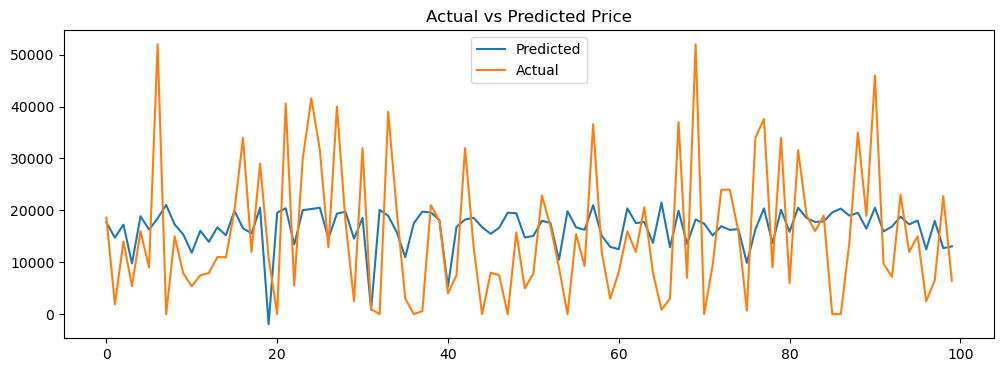

In [56]:
# Create a baseline linear regression model using only numerical features
X_train_1 = X_train[['year', 'odometer']]
X_test_1 = X_test[['year', 'odometer']]

# Initiate the model 
model1 = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]).fit(X_train_1, y_train)
y_pred_1 = model1.predict(X_test_1)

#Evaluate the model 
score['Model 1'] = evaluate_model(model1, y_test, y_pred_1)
score 

##### _Step 13: Model 2 - Train with condition data as well_


,Model 1,Model 2
RMSE,1.510569e+08,1.504175e+08
MAE,9.832646e+03,9.781276e+03


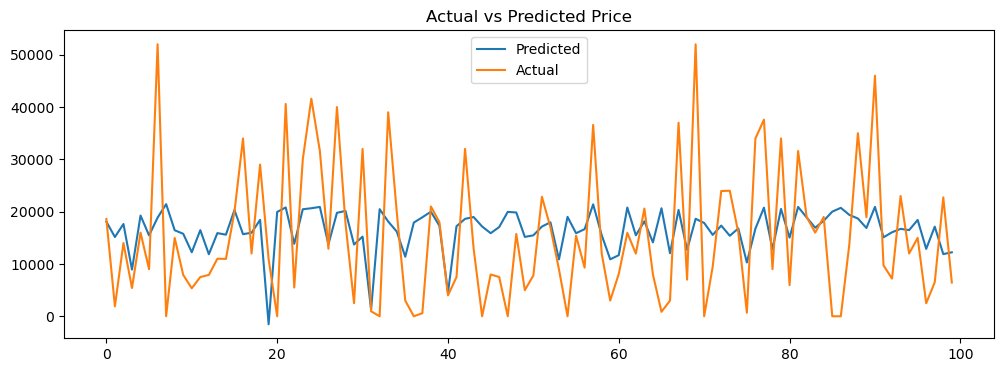

In [57]:
# Create a new training set with one more feature, condition
X_train_2 = X_train[['year', 'odometer', 'condition']]
X_test_2 = X_test[['year', 'odometer', 'condition']]

# Initiate the model 
model2 = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]).fit(X_train_2, y_train)
y_pred_2 = model2.predict(X_test_2)

#Evaluate the model 
score['Model 2'] = evaluate_model(model2, y_test, y_pred_2)
score 

##### _Step 14: Model 3 - Work in the Categorical Features_


,Model 1,Model 2,Model 3
RMSE,1.510569e+08,1.504175e+08,1.228780e+08
MAE,9.832646e+03,9.781276e+03,8.351544e+03


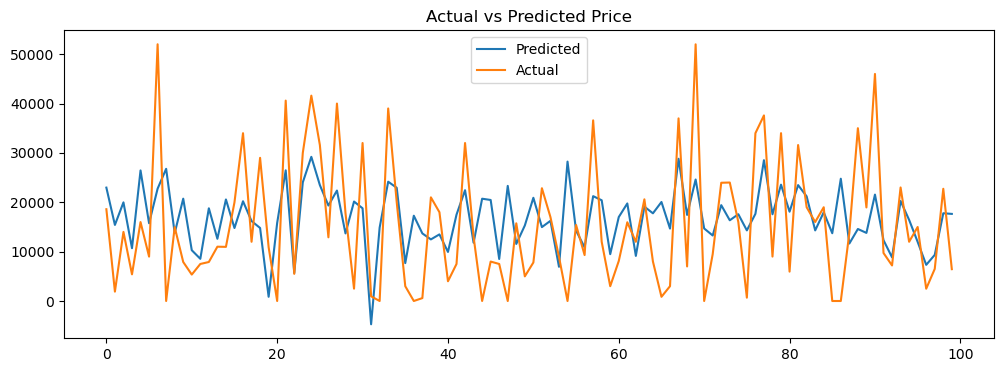

In [58]:
# Initiate the model 
model3 = Pipeline([('scaler', StandardScaler()), ('lr', LinearRegression())]).fit(X_train, y_train)
y_pred_3 = model3.predict(X_test)

#Evaluate the model 
score['Model 3'] = evaluate_model(model3, y_test, y_pred_3)
score

##### _Step 15: Model 4 - Try the Ridge Regression Model_

The best fit alpha value is: {'ridge__alpha': 50}


,Model 1,Model 2,Model 3,Model 4 (Ridge)
RMSE,1.510569e+08,1.504175e+08,1.228780e+08,1.228785e+08
MAE,9.832646e+03,9.781276e+03,8.351544e+03,8.351761e+03


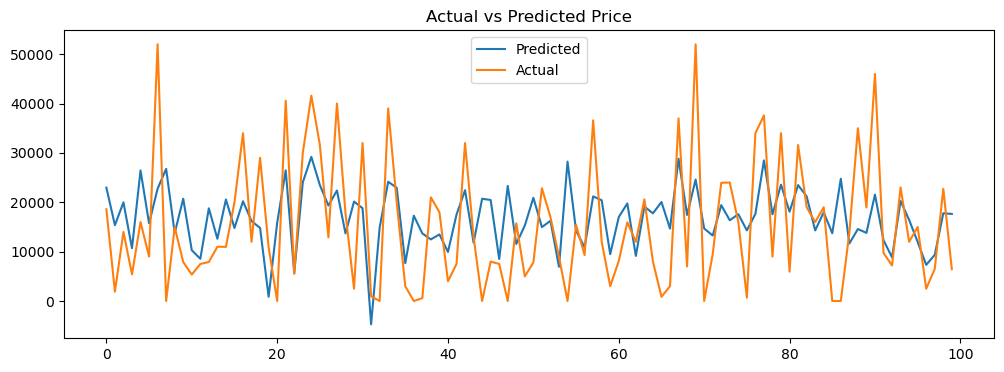

In [59]:
# Initiate a pipeline with standard scaler and ridge regressor 
ridge_pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
 
# Find the best alpha using GridSearchCV
parameters = {'ridge__alpha': [1e-10,1e-2,1,5,10,20,50,100]}
ridge_regressor = GridSearchCV(ridge_pipeline, parameters, scoring='neg_mean_squared_error', cv=5)

# Fitting model
ridge_regressor.fit(X_train, y_train)

# Getting optimum parameters
print("The best fit alpha value is:" ,ridge_regressor.best_params_)
     
# Initiate ridge pipeline with best alpha
best_alpha = ridge_regressor.best_params_['ridge__alpha']
ridge_pipeline_best = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge(alpha=best_alpha))])

# Fit the ridge regression model to your training data
ridge_pipeline_best.fit(X_train, y_train)

# Predict on model
y_pred_ridge = ridge_pipeline_best.predict(X_test)

# Evaluation matrices for Ridge regression
result = evaluate_model(ridge_pipeline_best, y_test, y_pred_ridge)

score['Model 4 (Ridge)'] = result
score

In [64]:
# Access the preprocessor step
preprocessor = ridge_pipeline_best.named_steps['scaler']

# Get the transformed feature names
# For StandardScaler, the feature names remain the same
feature_names = X_train.columns.tolist()

# Access the fitted Ridge model and its coefficients
ridge_model = ridge_pipeline_best.named_steps['ridge'] 
coefficients = ridge_model.coef_

# Examine the top 20 features that were most impactful in predicting price
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
sorted_coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)
print(sorted_coef_df[['Feature', 'Coefficient']].head(20))

                       Feature  Coefficient
0                         year  4515.350986
43                 type_pickup  2591.496270
10           manufacturer_ford -2582.518171
7       manufacturer_chevrolet -2372.981539
34                   drive_fwd -1515.167744
42                  type_other  1476.307982
9           manufacturer_dodge -1443.033844
45                  type_truck  1378.781472
21         manufacturer_nissan -1377.359453
2                     odometer -1370.904562
32       cylinders_8 cylinders  1218.890494
38                  type_coupe  1163.248495
12          manufacturer_honda -1100.931026
11            manufacturer_gmc -1045.255589
8        manufacturer_chrysler  -864.286588
4             manufacturer_bmw  -859.853498
16            manufacturer_kia  -844.365476
13        manufacturer_hyundai  -832.217373
25         manufacturer_toyota  -816.489939
20  manufacturer_mercedes-benz  -807.925625


##### _Step 16: Model 5 - Try the Decision Tree Model_

In [60]:
#Initiate and Fit a Decision Tree Regressor model
model5 = DecisionTreeRegressor(random_state=42)
model5.fit(X_train, y_train)
model5_pred = model5.predict(X_test)  

,Model 1,Model 2,Model 3,Model 4 (Ridge),Model 5 (Decision Tree)
RMSE,1.510569e+08,1.504175e+08,1.228780e+08,1.228785e+08,6.082660e+07
MAE,9.832646e+03,9.781276e+03,8.351544e+03,8.351761e+03,3.348590e+03


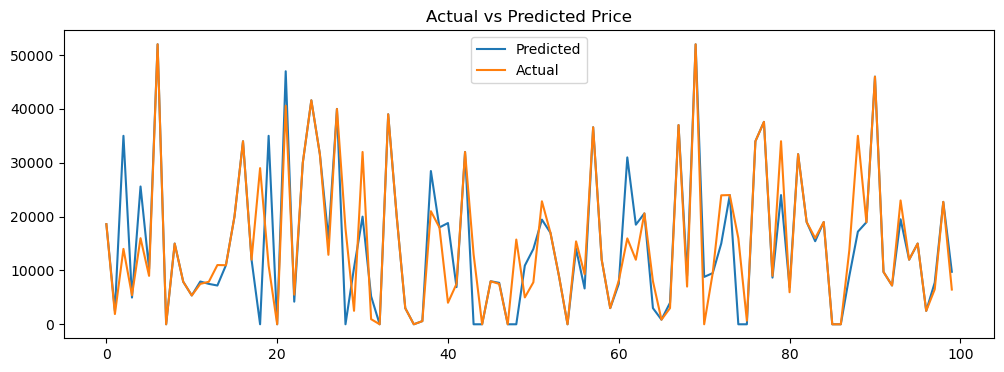

In [61]:
# Evaluate the model 
result = evaluate_model(model5, y_test, model5_pred)
score['Model 5 (Decision Tree)'] = result
score

In [65]:
# Get the feature importances
importances = model5.feature_importances_

# Get the feature names from the training data
feature_names = X_train.columns

# Create a DataFrame to display the importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the features by importance in descending order
sorted_importance = importance_df.sort_values(by='Importance', ascending=False)

print(sorted_importance)

                       Feature  Importance
2                     odometer    0.362607
0                         year    0.315432
29       cylinders_4 cylinders    0.050002
34                   drive_fwd    0.039571
1                    condition    0.027914
32       cylinders_8 cylinders    0.018517
43                 type_pickup    0.017802
35                   drive_rwd    0.012913
23            manufacturer_ram    0.012757
44                  type_sedan    0.012337
45                  type_truck    0.011413
25         manufacturer_toyota    0.011060
22         manufacturer_others    0.010189
10           manufacturer_ford    0.009547
7       manufacturer_chevrolet    0.008711
31       cylinders_6 cylinders    0.006955
42                  type_other    0.006241
11            manufacturer_gmc    0.006004
9           manufacturer_dodge    0.005132
38                  type_coupe    0.004291
20  manufacturer_mercedes-benz    0.004259
17          manufacturer_lexus    0.004190
15         

**Important Features** 

Based on the important coefficients of the Ridge Model (Model 4) and the importance of the features in the Decision Tree Model (Model 5), the following were observed: 

a. The `year` is a top factor in both models in determining price.  
b. The `type` valued by both models are pickup trucks.  
c. The `cylinder` type is more valued in the decision tree model.  
d. The `manufacturer` type affects price prediction in both models.   

## D. Evaluation

**Choose a suitable evaluation metric** 

The Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE) are both simple and straightforward ways of measuring prediciton error. Both RMSE and MAE are useful. The RMSE, due to its squaring operation, tends to penalise outliers more, and can be seen from the results. This can be valuable if we want to minimise errors in predicting the value of a car, resulting in overpaying for something less valuable. However, we also note that outliers can exist in the dataset (e.g. antiques) and are reasonable, hence we retained the MAE for a more general overall view and prediciton error to prevent the model from being too affected by outliers. 

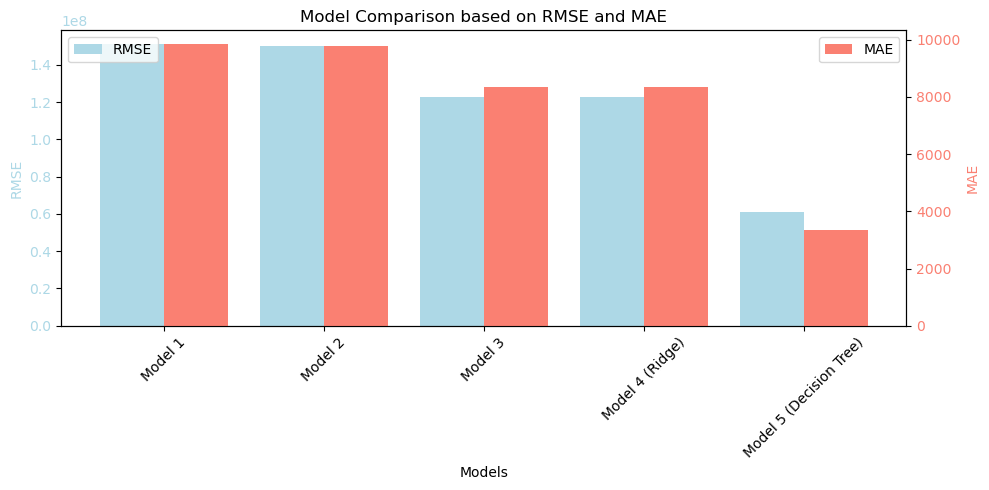

In [62]:
#Plot rmse/mae scores for each model 
models = list(score.columns)
rmse_scores = score.loc['RMSE'].values
mae_scores = score.loc['MAE'].values

X_axis = np.arange(len(models))

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot RMSE on the primary y-axis (left)
ax1.bar(X_axis - 0.2, rmse_scores, 0.4, label='RMSE', color='lightblue')
ax1.set_xlabel("Models")
ax1.set_ylabel("RMSE", color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')
ax1.set_ylim(bottom=0) # Ensure y-axis starts at 0

# Create a secondary y-axis for MAE (right)
ax2 = ax1.twinx()
ax2.bar(X_axis + 0.2, mae_scores, 0.4, label='MAE', color='salmon')
ax2.set_ylabel("MAE", color='salmon')
ax2.tick_params(axis='y', labelcolor='salmon')
ax2.set_ylim(bottom=0) # Ensure y-axis starts at 0

# Set up the rest of the plot
ax1.set_xticks(X_axis)
ax1.set_xticklabels(models, rotation=45)
ax1.set_title("Model Comparison based on RMSE and MAE")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()  

**Recommendation**

From the analysis, the Decision Tree model was clearly superior, likely due to the number of categorical features we have that were deterministic in swaying the likely target value. In this case, the Decision Tree model is more versatile. It was also clear comparing RMSE and MAE that the dataset still contains significant outliers, which the RMSE had penalised disproportionately more than the MAE. 

If we want to push this further, we could fine tune the decision tree model with GridSearchCV or RandomizedSearchCV, to explore a wider range of values for each parameter. 


## E. Deployment

The project was initiated to help make recommendations to the client - a car dealership - on how to predict the value of resale car prices to finetune its decisions on what to incorporate into its inventory. 

The model that was best fit to attempt this prediciton as a Decision Tree model (model 5) given the nature of thea features that were deterministic in price prediction. 

**Key Insights** 

a. The 'year' of a car does not have strong correlation to its price but was listed in both ridge and decision tree models as an important feature. At its extremes (e.g. when it is an antique car), the price can be significantly higher. The client should consider the value of high value **antiques** if it considers itself an antique resaler. 

b. The 'odometer' mileage should be as low as possible, or very high (when it is an antique). 

c. The 'model' to consider that either generate high sale price, or high sale volume (resulting in generally high sale value) are **mercedes-benz, chevrolet, volvo, ford and toyota**. Brands such as jeep and nissan are also relatively popular. 

d. The 'fuel', 'transmission', 'title_status' preferred are **'gas', 'automatic', and 'clean'**. Do not consider other types. 

e. The 'color' does not really matter. 

f. The 'state' that tends to have higher sales prices are West Virginia, Montana, and Alaska. Client can consider setting up franchises there. 

The **decision tree model** was best fit for analysing this dataset since many of the determining features were categorical in nature, especially in terms of car model based on its weightage given in the eventual modelling. 